In [1]:

import joblib

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import tensorflow as tf

import nltk
from nltk.corpus import stopwords


In [2]:
file_path = 'AMAZON_FASHION.json.gz'


df = pd.read_json(file_path, compression='gzip', lines=True)


# Dataset Exploration

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

asin - ID of the product, e.g. 0000013714

reviewerName - name of the reviewer


vote - helpful votes of the review

style - a dictionary of the product metadata, e.g., "Format" is "Hardcover"

reviewText - text of the review

overall - rating of the product

summary - summary of the review

unixReviewTime - time of the review (unix time)

reviewTime - time of the review (raw)

image - images that users post after they have received the product





In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [5]:
df.count()

overall           883636
verified          883636
reviewTime        883636
reviewerID        883636
asin              883636
reviewerName      883544
reviewText        882403
summary           883103
unixReviewTime    883636
vote               79900
style             304569
image              28807
dtype: int64

In [6]:
df.describe()

,overall,unixReviewTime,vote
count,883636.00000,8.836360e+05,79900.000000
mean,3.90694,1.456751e+09,5.797434
std,1.41828,4.430691e+07,12.365278
min,1.00000,1.036973e+09,2.000000
25%,3.00000,1.434240e+09,2.000000
50%,5.00000,1.462234e+09,3.000000
75%,5.00000,1.484266e+09,5.000000
max,5.00000,1.538352e+09,966.000000


In [7]:
#Dropping image column because there are too many missing values for the data to be usefull
df.drop('image', axis=1, inplace=True)

In [8]:
df.drop('vote', axis=1, inplace=True)

In [9]:
# Dropping all missing values
df.dropna(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303858 entries, 7 to 883601
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         303858 non-null  int64 
 1   verified        303858 non-null  bool  
 2   reviewTime      303858 non-null  object
 3   reviewerID      303858 non-null  object
 4   asin            303858 non-null  object
 5   reviewerName    303858 non-null  object
 6   reviewText      303858 non-null  object
 7   summary         303858 non-null  object
 8   unixReviewTime  303858 non-null  int64 
 9   style           303858 non-null  object
dtypes: bool(1), int64(2), object(7)
memory usage: 23.5+ MB


In [11]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style
7,3,True,"09 22, 2013",A1BB77SEBQT8VX,B00007GDFV,Darrow H Ankrum II,mother - in - law wanted it as a present for h...,bought as a present,1379808000,{'Color:': ' Black'}
8,3,True,"07 17, 2013",AHWOW7D1ABO9C,B00007GDFV,rosieO,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,1374019200,{'Color:': ' Black'}
9,3,True,"04 13, 2013",AKS3GULZE0HFC,B00007GDFV,M. Waltman,I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!,1365811200,{'Color:': ' Black'}
10,4,True,"03 9, 2013",A38NS6NF6WPXS,B00007GDFV,BTDoxies,This brand has been around a long time and you...,BUXTON QUALITY!,1362787200,{'Color:': ' Black'}
11,2,True,"01 27, 2013",A1KOKO3HTSAI1H,B00007GDFV,Robin Howard,I smoke 100's and these are NOT made for them....,Buxton Heiress Collection Black Leather Cigare...,1359244800,{'Color:': ' Black'}


In [12]:
# Removing reviews from users who review the same product multiple times
unique_cols = ['reviewerID', 'asin']

# Find duplicates based on these unique columns. `keep=False`will drop both the orignal and any extra duplicates.
duplicates = df[df.duplicated(subset=unique_cols)]

# Count the number of duplicates
num_duplicates = duplicates.count()

# Print the number of duplicates
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: overall           5761
verified          5761
reviewTime        5761
reviewerID        5761
asin              5761
reviewerName      5761
reviewText        5761
summary           5761
unixReviewTime    5761
style             5761
dtype: int64


In [13]:
df.drop_duplicates(subset=unique_cols, inplace=True)


In [14]:
df.count()

overall           298097
verified          298097
reviewTime        298097
reviewerID        298097
asin              298097
reviewerName      298097
reviewText        298097
summary           298097
unixReviewTime    298097
style             298097
dtype: int64

In [15]:
df['style'] = df['style'].astype(str)


In [16]:
print("Unique styles:")
for style in df['style'].unique():
    print(style)

Unique styles:
{'Color:': ' Black'}
{'Size:': ' 17 - 37', 'Color:': ' White'}
{'Size:': ' 16.5 - 33', 'Color:': ' White'}
{'Size:': ' 16.5 - 37', 'Color:': ' Grey'}
{'Size:': ' 16 - 35', 'Color:': ' Blue'}
{'Size:': ' 19 - 35', 'Color:': ' White'}
{'Size:': ' 16 - 34', 'Color:': ' White'}
{'Size:': ' 18 - 36', 'Color:': ' White'}
{'Size:': ' 18.5 - 36', 'Color:': ' White'}
{'Size:': ' 18.5 - 37', 'Color:': ' White'}
{'Size:': ' 17 - 35', 'Color:': ' White'}
{'Size:': ' 17 - 34', 'Color:': ' White'}
{'Size:': ' 17.5 - 37', 'Color:': ' White'}
{'Size:': ' 16.5 - 35', 'Color:': ' Ecru'}
{'Size:': ' 19 - 36', 'Color:': ' Blue Stripe'}
{'Size:': ' 16 - 34', 'Color:': ' Blue'}
{'Size:': ' 15 - 32', 'Color:': ' Blue Stripe'}
{'Size:': ' 19 - 37', 'Color:': ' French Blue'}
{'Size:': ' 19 - 37', 'Color:': ' Blue'}
{'Size:': ' 16.5 - 32', 'Color:': ' Ecru'}
{'Size:': ' 19 - 36', 'Color:': ' White'}
{'Size:': ' 18 - 37', 'Color:': ' Aqua'}
{'Size:': ' 17.5 - 36', 'Color:': ' Yellow'}
{'Size:': ' 

In [17]:
df['style'].nunique()

34222

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298097 entries, 7 to 883601
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         298097 non-null  int64 
 1   verified        298097 non-null  bool  
 2   reviewTime      298097 non-null  object
 3   reviewerID      298097 non-null  object
 4   asin            298097 non-null  object
 5   reviewerName    298097 non-null  object
 6   reviewText      298097 non-null  object
 7   summary         298097 non-null  object
 8   unixReviewTime  298097 non-null  int64 
 9   style           298097 non-null  object
dtypes: bool(1), int64(2), object(7)
memory usage: 23.0+ MB


In [19]:
style_counts = df['style'].value_counts()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298097 entries, 7 to 883601
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         298097 non-null  int64 
 1   verified        298097 non-null  bool  
 2   reviewTime      298097 non-null  object
 3   reviewerID      298097 non-null  object
 4   asin            298097 non-null  object
 5   reviewerName    298097 non-null  object
 6   reviewText      298097 non-null  object
 7   summary         298097 non-null  object
 8   unixReviewTime  298097 non-null  int64 
 9   style           298097 non-null  object
dtypes: bool(1), int64(2), object(7)
memory usage: 23.0+ MB


In [21]:
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['overall'].apply(label_sentiment)

C:\Users\hasee\AppData\Local\Temp\ipykernel_18364\2336848550.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette=['orangered', 'gold', 'steelblue'])


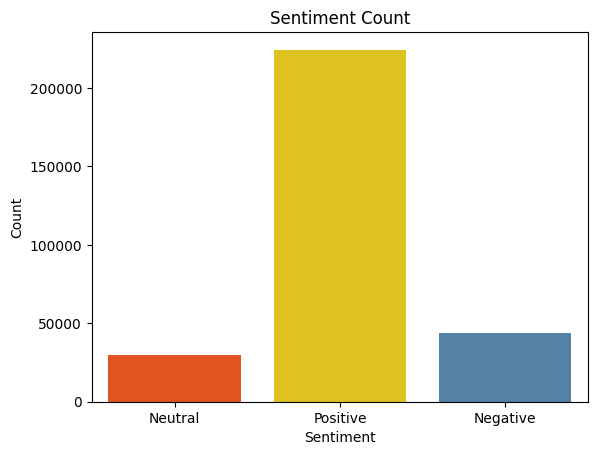

In [22]:
sns.countplot(data=df, x='sentiment', palette=['orangered', 'gold', 'steelblue'])
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

[]

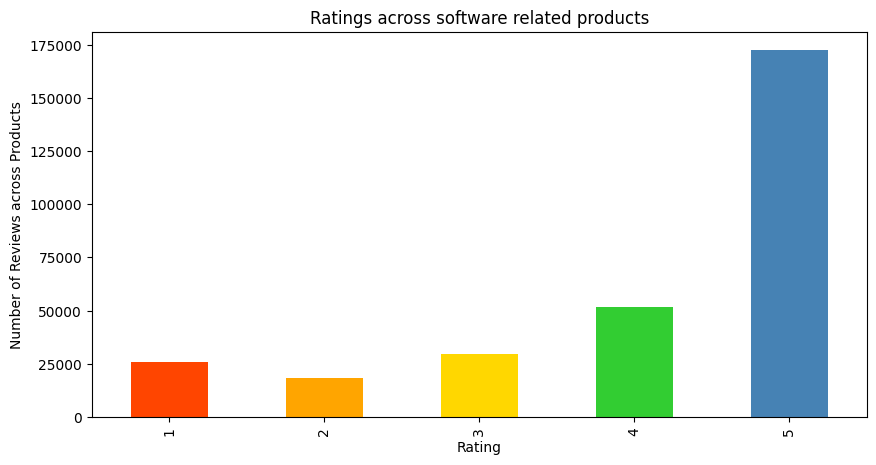

In [23]:
overall_distribution = df['overall'].value_counts().sort_index().plot(kind='bar',
                                               title='Ratings across software related products',
                                               color=('orangered','orange','gold','limegreen','steelblue'),
                                               figsize=(10,5))
overall_distribution.set_ylabel('Number of Reviews across Products')
overall_distribution.set_xlabel('Rating')
overall_distribution.plot()

[]

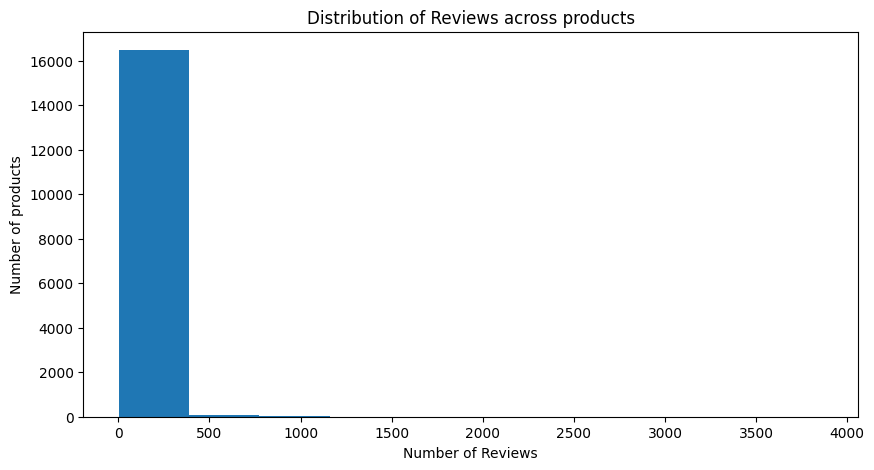

In [24]:
reviews_across_products = df['asin'].value_counts().sort_index().plot(kind='hist',
                                               title='Distribution of Reviews across products',
                                               figsize=(10,5))
reviews_across_products.set_xlabel('Number of Reviews')
reviews_across_products.set_ylabel('Number of products')
reviews_across_products.plot()

[]

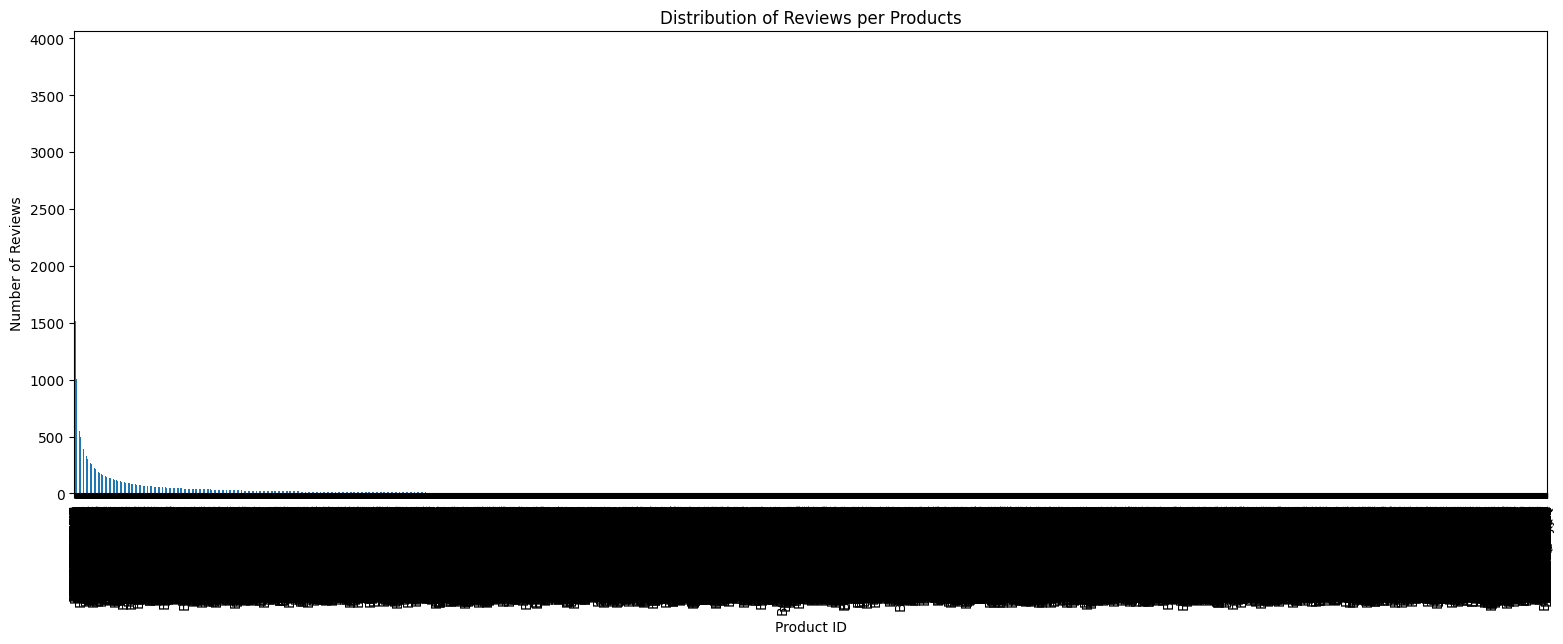

In [25]:
reviews_per_product=df['asin'].value_counts().plot(kind='bar',
                               title='Distribution of Reviews per Products',
                               figsize=(19,6))
reviews_per_product.set_xlabel('Product ID')
reviews_per_product.set_ylabel("Number of Reviews")
reviews_per_product.plot()

In [26]:
reviews_per_user = df['reviewerID'].value_counts()
print(reviews_per_user)

reviewerID
A3VGHF7VNFBMCQ    12
AS378UOMHULXO     11
ACDIEMICS7XGC     10
A3UTTXFSBNV2V7     9
AODFGQL9CC7G7      9
                  ..
A1CGU3AUZI8970     1
A3U2DCADYOK9U8     1
A3OIDDG7KXZBHJ     1
A3JD8VX2A2V8KS     1
A22XA0XZ1DVLMU     1
Name: count, Length: 275871, dtype: int64


[]

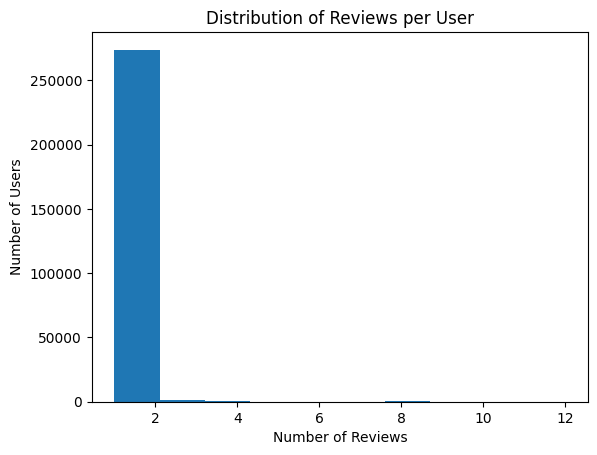

In [27]:
reviews_per_user =reviews_per_user.plot(kind='hist', title='Distribution of Reviews per User')
reviews_per_user.set_xlabel('Number of Reviews')
reviews_per_user.set_ylabel('Number of Users')
reviews_per_user.plot()

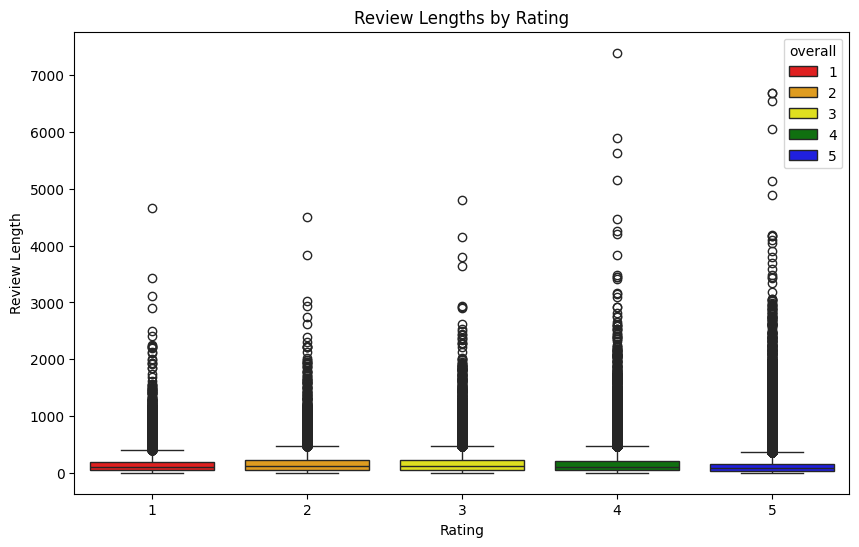

In [28]:
df['review_length'] = df['reviewText'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='review_length', data=df, hue="overall", palette =['red','orange','yellow','green','blue'])
plt.title("Review Lengths by Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.show()

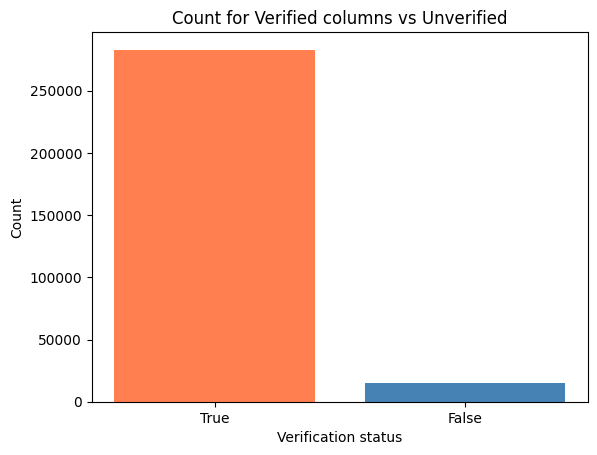

In [29]:
counts = df['verified'].value_counts()

# Create the bar plot
plt.bar(counts.index.astype(str), counts, color=('coral','steelblue'))


plt.xlabel('Verification status')
plt.ylabel('Count')
plt.title('Count for Verified columns vs Unverified')

# Show the plot
plt.show()

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

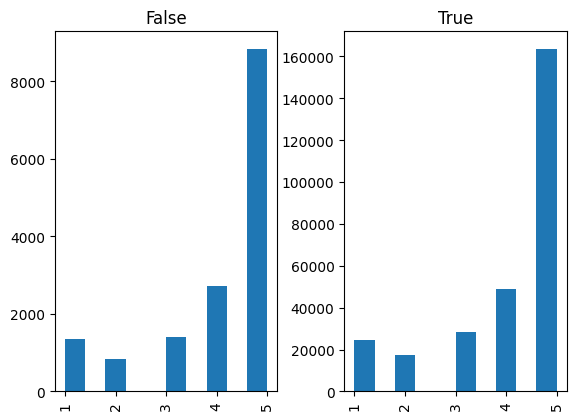

In [30]:
df.hist(column='overall', by='verified')

In [31]:
df = df[df['verified'] == True]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 282924 entries, 7 to 883601
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         282924 non-null  int64 
 1   verified        282924 non-null  bool  
 2   reviewTime      282924 non-null  object
 3   reviewerID      282924 non-null  object
 4   asin            282924 non-null  object
 5   reviewerName    282924 non-null  object
 6   reviewText      282924 non-null  object
 7   summary         282924 non-null  object
 8   unixReviewTime  282924 non-null  int64 
 9   style           282924 non-null  object
 10  sentiment       282924 non-null  object
 11  review_length   282924 non-null  int64 
dtypes: bool(1), int64(3), object(8)
memory usage: 26.2+ MB


Text preprocessing For lexicon and Machine learning models

In [33]:
columns = ['reviewText','summary','sentiment','overall','asin']
new_df = df[columns]


In [34]:
new_df['text'] = new_df['summary'] + ' ' +  new_df['reviewText']
new_df = new_df.drop(columns=['reviewText','summary'])

C:\Users\hasee\AppData\Local\Temp\ipykernel_18364\229088158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['text'] = new_df['summary'] + ' ' +  new_df['reviewText']


In [35]:
new_df

,sentiment,overall,asin,text
7,Neutral,3,B00007GDFV,bought as a present mother - in - law wanted i...
8,Neutral,3,B00007GDFV,Buxton heiress collection Item is of good qual...
9,Neutral,3,B00007GDFV,Top Clasp Broke Within 3 days! I had used my l...
10,Positive,4,B00007GDFV,BUXTON QUALITY! This brand has been around a l...
11,Negative,2,B00007GDFV,Buxton Heiress Collection Black Leather Cigare...
...,...,...,...,...
883597,Positive,5,B01HJGJ9LS,"good hats! Great hats, thank you!"
883598,Positive,4,B01HJGJ9LS,Four Stars Material feels very inexpensive but...
883599,Positive,5,B01HJGJ9LS,nice hat Nice hat to wear fishing fits good.
883600,Positive,5,B01HJGJ9LS,Five Stars It a perfect it! made well.


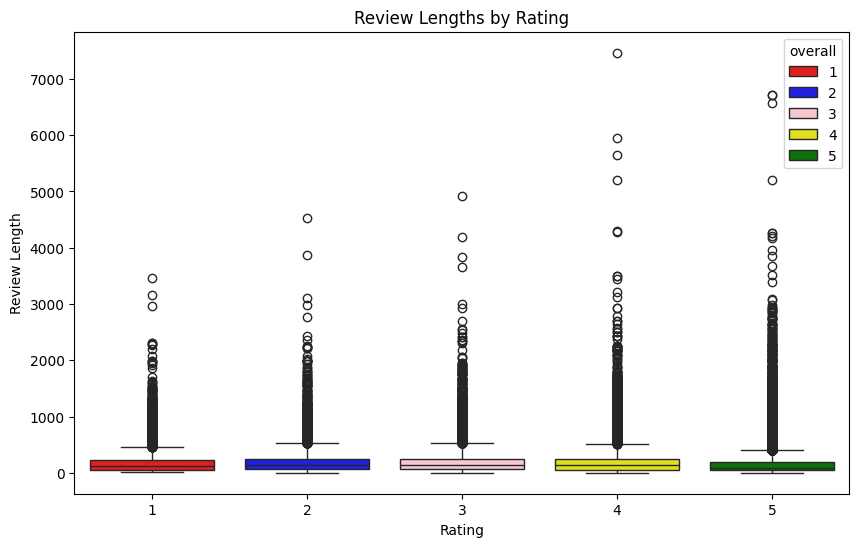

In [36]:
new_df['text_length'] = new_df['text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='text_length', data=new_df, hue="overall", palette=['red', 'blue', 'pink','yellow', 'green'])
plt.title("Review Lengths by Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.show()

In [37]:
new_df['Index'] = range(1, len(new_df) + 1)

In [38]:
new_df

,sentiment,overall,asin,text,text_length,Index
7,Neutral,3,B00007GDFV,bought as a present mother - in - law wanted i...,113,1
8,Neutral,3,B00007GDFV,Buxton heiress collection Item is of good qual...,366,2
9,Neutral,3,B00007GDFV,Top Clasp Broke Within 3 days! I had used my l...,959,3
10,Positive,4,B00007GDFV,BUXTON QUALITY! This brand has been around a l...,151,4
11,Negative,2,B00007GDFV,Buxton Heiress Collection Black Leather Cigare...,177,5
...,...,...,...,...,...,...
883597,Positive,5,B01HJGJ9LS,"good hats! Great hats, thank you!",33,282920
883598,Positive,4,B01HJGJ9LS,Four Stars Material feels very inexpensive but...,72,282921
883599,Positive,5,B01HJGJ9LS,nice hat Nice hat to wear fishing fits good.,44,282922
883600,Positive,5,B01HJGJ9LS,Five Stars It a perfect it! made well.,38,282923


In [39]:
new_df

,sentiment,overall,asin,text,text_length,Index
7,Neutral,3,B00007GDFV,bought as a present mother - in - law wanted i...,113,1
8,Neutral,3,B00007GDFV,Buxton heiress collection Item is of good qual...,366,2
9,Neutral,3,B00007GDFV,Top Clasp Broke Within 3 days! I had used my l...,959,3
10,Positive,4,B00007GDFV,BUXTON QUALITY! This brand has been around a l...,151,4
11,Negative,2,B00007GDFV,Buxton Heiress Collection Black Leather Cigare...,177,5
...,...,...,...,...,...,...
883597,Positive,5,B01HJGJ9LS,"good hats! Great hats, thank you!",33,282920
883598,Positive,4,B01HJGJ9LS,Four Stars Material feels very inexpensive but...,72,282921
883599,Positive,5,B01HJGJ9LS,nice hat Nice hat to wear fishing fits good.,44,282922
883600,Positive,5,B01HJGJ9LS,Five Stars It a perfect it! made well.,38,282923


In [40]:
def select_balanced_subset(df, min_reviews_per_class):
    # select an even distribution of sentiments up to min_reviews_per_class
    subsets = []
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        sentiment_subset = new_df[new_df['sentiment'] == sentiment]

        # If there are more reviews than min_reviews_per_class, downsample
        if len(sentiment_subset) > min_reviews_per_class:
            sentiment_subset = sentiment_subset.sample(n=min_reviews_per_class, random_state=42)
        subsets.append(sentiment_subset)

    # Concatenate subsets to form a balanced dataset
    balanced_df = pd.concat(subsets, ignore_index=True)

    return balanced_df


# Example usage:
# balanced_data = select_balanced_subset(your_dataframe, min_reviews_per_class)


In [41]:
subset_df = select_balanced_subset(new_df, min_reviews_per_class=2000)

In [42]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentiment    6000 non-null   object
 1   overall      6000 non-null   int64 
 2   asin         6000 non-null   object
 3   text         6000 non-null   object
 4   text_length  6000 non-null   int64 
 5   Index        6000 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 281.4+ KB


In [43]:
subset_df

,sentiment,overall,asin,text,text_length,Index
0,Positive,5,B004YFVACE,Great Beautiful belt. I love the design and co...,153,223185
1,Positive,5,B00RLSCLJM,Absolutely love this ring Absolutely love this...,239,128361
2,Positive,5,B00PDACJ42,super cute. love this super cute. love this. i...,188,121823
3,Positive,4,B004K3J7LG,great seller they were a quick shipper and the...,132,41391
4,Positive,4,B000NBIMY2,Great flip flop I normally wear a 10 in flip f...,309,11742
...,...,...,...,...,...,...
5995,Negative,2,B0167ZFTSY,I don't feel like the product was marketed in ...,1579,263696
5996,Negative,2,B00QDJ4SV4,Two Stars Turned my neck green.,31,247626
5997,Negative,1,B01AMSIDI0,One Star Order a size smaller. Way big,38,270824
5998,Negative,1,B00S9VIU4K,One Star Too big,16,249159


[]

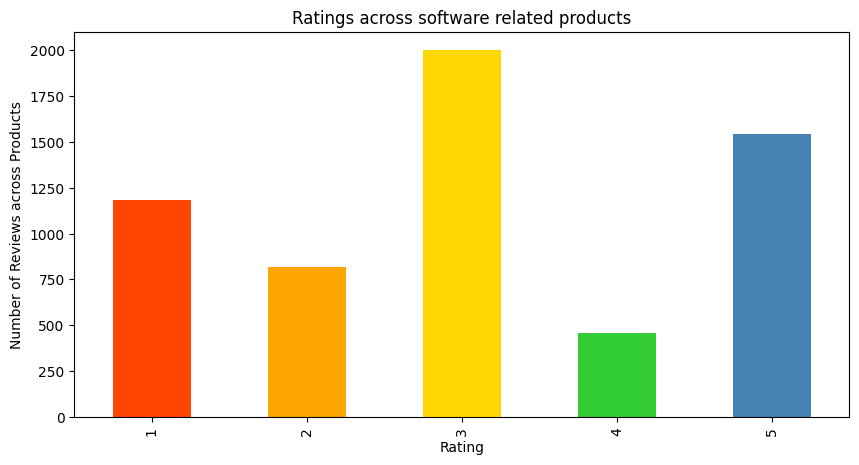

In [44]:
overall_distribution = subset_df['overall'].value_counts().sort_index().plot(kind='bar',
                                               title='Ratings across software related products',
                                               color=('orangered','orange','gold','limegreen','steelblue'),
                                               figsize=(10,5))
overall_distribution.set_ylabel('Number of Reviews across Products')
overall_distribution.set_xlabel('Rating')
overall_distribution.plot()

C:\Users\hasee\AppData\Local\Temp\ipykernel_18364\3049730025.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=subset_df, x='sentiment', palette=['orangered', 'gold', 'steelblue'])


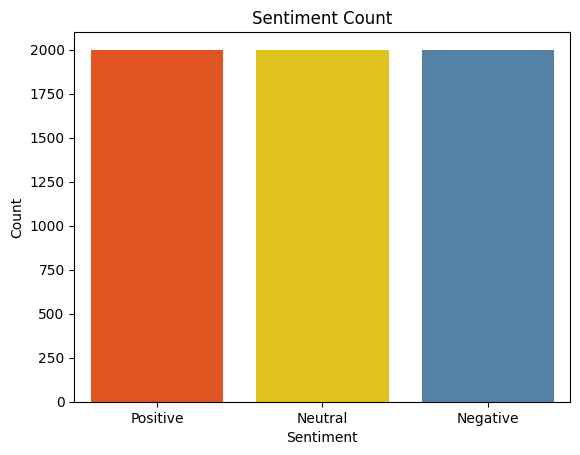

In [45]:
sns.countplot(data=subset_df, x='sentiment', palette=['orangered', 'gold', 'steelblue'])
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [46]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
stop_words = set(stopwords.words('english'))
negations = {"not", "n't", "no","never", "don't", "isn't"}
custom_stopwords = stop_words - negations
#remove stop words except negations words like no not which can change the context


In [48]:
pd.set_option('display.max_colwidth', None)
subset_df.head(30)


,sentiment,overall,asin,text,text_length,Index
0,Positive,5,B004YFVACE,Great Beautiful belt. I love the design and color. It is all leather. It looks great with jeans. I will definitely purchase another in a different color.,153,223185
1,Positive,5,B00RLSCLJM,"Absolutely love this ring Absolutely love this ring, especially for the price! After reading reviews, I was worried about the color matching my white gold ring but it matches perfectly. The ring fits great and I received it very quickly.",239,128361
2,Positive,5,B00PDACJ42,super cute. love this super cute. love this. it fits perfectly. the skirt is Velcro so it has room to tighten or loosen when putting it on. great price for the whole outfit. decent quality,188,121823
3,Positive,4,B004K3J7LG,great seller they were a quick shipper and the product was as described. the price was far and I would recommend them to my friends,132,41391
4,Positive,4,B000NBIMY2,"Great flip flop I normally wear a 10 in flip flops, to get the smidge of extra shoe after the heel, and this 9/10 size does not offer enough of that smidge. But I think a size up would not have looked right. There is no arch support. But the sole and shoe is sturdy. Good shoe, but I have had ones more comfy.",309,11742
5,Positive,5,B0140UN3CC,"Five Stars I Love this Watch, very beautiful, however, it is snug.",66,167674
6,Positive,5,B00G8Q7JZ4,"I love this ring I love this ring! It is a perfect fit, and was shipped to me so swiftly. Would definitely order from MJ Metals Jewelry in the future",149,87651
7,Positive,5,B006111O7K,Five Stars This size too large,30,224759
8,Positive,5,B000YFSR5G,"Best sweatpants I ever bought. These are the best pair of sweat pants I have ever bought. Very comfortable and the length is perfect, something the ones I bought in the past were not. I would not hesitate to buy another pair like them.",237,21420
9,Positive,5,B01GGEQSWM,Five Stars Very nice fits just right will be ordering more colors,65,214637


In [49]:
subset_df[subset_df['sentiment'] == 'Neutral'].head(30)



,sentiment,overall,asin,text,text_length,Index
2000,Neutral,3,B01G69HXPI,Personally i do think it is a good product. My only complaint is that it looks ... I purchased this as I am always sure to cover up in this SoCal Heat. Personally i do think it is a good product. My only complaint is that it looks to be a swimsuit cover up due to the fabric.,276,280601
2001,Neutral,3,B00NIVAEG8,"Works great for the sun, not very durable The hat worked great for keeping the sun out of your face, but after using it for a week at the beach the woven material at the top of the hat began to crack. It still functions fine but I am not sure how many more uses it will have.",276,116061
2002,Neutral,3,B001DJ5J3U,"A little short for long legged ladies I'm 5'7 and can nearly pull the stockings up to my mid-upper thigh. I'd like to wear these under a dress with knee high boots, but I don't know if it'll work considering that fabric just seems not too stretchy. If all else fails I suppose I can wear them for Halloween.",307,25796
2003,Neutral,3,B01AN6M6L6,IT MAKES A GREAT SHIRT FOR LAYERING THE COLOR IS A LITTLE OFF. THAT GREEN IS TOO ODD LOOKING. BUT THE SHAPE AND CUT IS RIGHT ON POINT. IT MAKES A GREAT SHIRT FOR LAYERING.,171,270853
2004,Neutral,3,B01FO04LGE,"pretty see Also, pretty see thru",32,210476
2005,Neutral,3,B015FOT7SG,"Shipping is super fast Ship is super fast. True to the color, true to the size. But the Jacket is a disappointment, it says packable but no where can find the bag to ""pack"", it says ultra light, but it's actually heavier than my other down jackets.",248,172885
2006,Neutral,3,B01CF6TXL8,"It's shorter in the back than I would like (high at the waist) The fit is right through the bust, arms, waist, etc. It's shorter in the back than I would like (high at the waist).",180,198180
2007,Neutral,3,B00GKF5BAS,Three Stars sizing is off,25,89481
2008,Neutral,3,B00N86FYPY,Surprised and impressed! I had ordered this necklace for my best friend who is graduation cosmetology school in about a month. I wasn't really sure what the quality was going to be like but I was rather impressed! It's very heavy and seems like it's going to stand up to time. I will see how it wears when she has worn it for awhile but for now I am happy with my purchase.,373,114555
2009,Neutral,3,B00EZJEHEM,Bought the red before n it fits great but this green is two sizes too Sizing inconsistent. Bought the red before n it fits great but this green is two sizes too large,166,83009


In [50]:
subset_df.tail(100)

,sentiment,overall,asin,text,text_length,Index
5900,Negative,2,B015HZSDF6,Two Stars Way too long and not happy with the material,54,173114
5901,Negative,1,B00DV0FCMC,Too Short - Poor Quality The dresses were ridiculously short. The quality was very poor. The material reminded me of cheap convenience store children's Halloween costumes. I was very disappointed. The dresses photogragh much better than they actually look. I will not purchase from this supplier again.,302,78712
5902,Negative,2,B01604VQGG,Two Stars Changed colors,24,263416
5903,Negative,2,B0045D7VZ0,"Too Large overall each piece is just big\nOne of the hardest parts of the costume to get right is the ""boots"" it's as if you have to glue that down in order for It to look neat",175,38456
5904,Negative,1,B00HZ31VBC,"Poor quality. Very bad material quality, ended up throwing it out after 5-6 washes. Would not recommend",103,94549
...,...,...,...,...,...,...
5995,Negative,2,B0167ZFTSY,"I don't feel like the product was marketed in a way that was ... This item wasn't really what I was hopping for. I sized up after reading the reviews and then found that the item fit a little too large. The style itself also wasn't really what I expected. To be fair though, I don't feel like the product was marketed in a way that was misleading. What I got looks like the photographs. It just didn't wear the way I hopped. It fits as though it was meant for a much younger girl. There also isn't any curve to the sweater at all. If you are naturally curvy than the look of this top may be a bit more flattering on you. I'm not super curvy though (at least not up top) so I feel like I just looked a little childish in it.\n\nI can say that the material is quite nice. It arrived in good condition and is made from a thicker fabric. There is nothing wrong with the quality at all.\n\nI'm 5ft 5in, 123 lbs, a 29 in natural waist, and wear a 34b. My suggestion for smaller builds closer to mine would be to go with the small but if you've got more natural curves than go with the medium. My guess is that the smaller size would form to someone's body shape more and look less childish for potential buyers who's curves are a little less pronounced.\n\nAlso please note!!! This item ships from China so if you get he wrong size it will be very expensive to return. I went back and forth with Amazon customer service in an effort to find a solution (they were very helpful) but it was a process that not everyone will have the time or patience for. So be prepared to keep what you get. :)",1579,263696
5996,Negative,2,B00QDJ4SV4,Two Stars Turned my neck green.,31,247626
5997,Negative,1,B01AMSIDI0,One Star Order a size smaller. Way big,38,270824
5998,Negative,1,B00S9VIU4K,One Star Too big,16,249159


In [51]:
import re
import string
from nltk.tokenize import word_tokenize
def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        # Handle non-string inputs here. Options:
        # return an empty string, return the original input converted to string, etc.
        return ''  # or `return str(text)` to convert to string, but be cautious with 'nan' values


    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
   # text = re.sub(r'\b\w\b', '', text)  # Remove single characters
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords while preserving negations
    words = [w for w in words if w.lower() not in custom_stopwords]
    # Rejoin words into a string
    preprocessed_text = ' '.join(words)
    return preprocessed_text

subset_df['text'] = subset_df['text'].apply(preprocess_text)
subset_df

,sentiment,overall,asin,text,text_length,Index
0,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,223185
1,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,128361
2,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,121823
3,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,41391
4,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,11742
...,...,...,...,...,...,...
5995,Negative,2,B0167ZFTSY,dont feel like product marketed way item wasnt really hopping sized reading reviews found item fit little large style also wasnt really expected fair though dont feel like product marketed way misleading got looks like photographs didnt wear way hopped fits though meant much younger girl also isnt curve sweater naturally curvy look top may bit flattering im not super curvy though least not top feel like looked little childish say material quite nice arrived good condition made thicker fabric nothing wrong quality im ft lbs natural waist wear b suggestion smaller builds closer mine would go small youve got natural curves go medium guess smaller size would form someones body shape look less childish potential buyers whos curves little less pronounced also please note item ships china get wrong size expensive return went back forth amazon customer service effort find solution helpful process not everyone time patience prepared keep get,1579,263696
5996,Negative,2,B00QDJ4SV4,two stars turned neck green,31,247626
5997,Negative,1,B01AMSIDI0,one star order size smaller way big,38,270824
5998,Negative,1,B00S9VIU4K,one star big,16,249159


In [52]:

subset_df.head(30)

,sentiment,overall,asin,text,text_length,Index
0,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,223185
1,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,128361
2,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,121823
3,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,41391
4,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,11742
5,Positive,5,B0140UN3CC,five stars love watch beautiful however snug,66,167674
6,Positive,5,B00G8Q7JZ4,love ring love ring perfect fit shipped swiftly would definitely order mj metals jewelry future,149,87651
7,Positive,5,B006111O7K,five stars size large,30,224759
8,Positive,5,B000YFSR5G,best sweatpants ever bought best pair sweat pants ever bought comfortable length perfect something ones bought past not would not hesitate buy another pair like,237,21420
9,Positive,5,B01GGEQSWM,five stars nice fits right ordering colors,65,214637


In [53]:
subset_df.tail(30)

,sentiment,overall,asin,text,text_length,Index
5970,Negative,2,B00UJ6GUYA,wrap around top top wrap around figure put wont come youre water bottom ok,156,136669
5971,Negative,1,B009046YFW,ordered two sizes larger size ordered two sizes larger size way small not worth money also shorts not elastic waisted velcro closure no drawstring snap top unhappy,268,57082
5972,Negative,1,B00CQ9561G,no way sized us sizing ordered x daughter wears us yo lb grandaughter wearing,128,71133
5973,Negative,1,B00JBVX088,not able wear ordered dresses seller course attracted price design liked dresses add accessories wear sports bra see however dress one not adjusted bottom different compared one shown photo super short impossible wear,384,103007
5974,Negative,2,B00D3QZTTK,use soap couple nubras hoping would work bit better cleaning think using hand soap works much better watery doesnt really seem much,209,74104
5975,Negative,2,B00S4661VE,skulls got ring today beautiful skulls didnt look picture close enough notice skulls description doesnt mention definitely dont want engagement ring skulls unless im taking untill death us part quite literally,311,129740
5976,Negative,2,B013MUV3X2,two stars cheap material,24,166424
5977,Negative,1,B014QXL03W,poor quality small uncomfortable ordered sizes larger normal still dont fit excessively small front pouch even smaller pouch tight around assets limited amount space anyone endowed fabric fiberous resulting uncomfortable feel around wouldnt buy would recommend anyone buy dont look good uncomfortable,496,170913
5978,Negative,2,B00CY8ON68,price right pretty elastic tight felt like going snap everytime went put ended replacing elastic ribbon works fine mean price right,223,71732
5979,Negative,1,B00MRWCKR0,dont buy chinese piece junk dont give less star no lower rate waited almost month product ship actually china brings manual written chinese part english also qr code download app using phone code took page everything written chinese couldnt download anything didnt know watch came dead couldnt turn guess battery dead couldnt charge charger jack bigger opening watch cant charge cant use nothing words worst purchase ive ever done amazon dont believe none good experiences written product fake,868,243542


Vaders Model

In [54]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Define the custom sentiment analysis function
def custom_sentiment_analysis(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)

    # Define keywords indicating positive, neutral, and negative sentiment
    positive_keywords = ["five stars", "five star", "four stars", "four star"]
    neutral_keywords = ["three stars", "three star"]
    negative_keywords = ["one stars", "one star", "two stars", "two star"]

    # Check if any positive keyword is present in the text
    contains_positive_keyword = any(keyword in text for keyword in positive_keywords)

    # Check if any neutral keyword is present in the text
    contains_neutral_keyword = any(keyword in text for keyword in neutral_keywords)

    # Check if any negative keyword is present in the text
    contains_negative_keyword = any(keyword in text for keyword in negative_keywords)

    # If positive keyword is present, assign a very high positive score
    if contains_positive_keyword:
        return {'pos': 1.0, 'neg': 0.0, 'neu': 0.0, 'compound': 1.0}  # Very high positive score

    # If neutral keyword is present, assign a neutral score
    elif contains_neutral_keyword:
        return {'pos': 0.0, 'neg': 0.0, 'neu': 1.0, 'compound': 0.0}  # Neutral score

    # If negative keyword is present, assign a very high negative score
    elif contains_negative_keyword:
        return {'pos': 0.0, 'neg': 1.0, 'neu': 0.0, 'compound': -1.0}  # Very high negative score

    # If no keyword is present, use VADER for sentiment analysis
    else:
        sia = SentimentIntensityAnalyzer()
        return sia.polarity_scores(text)

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Iterate over the dataframe and perform sentiment analysis
result_vader = {}
for i, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    text = str(row['text'])  # convert all to string
    myid = row['Index']
    result_vader[myid] = custom_sentiment_analysis(text)  # Use custom sentiment analysis function

# Now result_vader contains sentiment scores with custom scoring for positive, neutral, and negative keywords



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/6000 [00:00<?, ?it/s]

In [56]:
result_vader

{223185: {'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.9638},
 128361: {'neg': 0.059, 'neu': 0.48, 'pos': 0.461, 'compound': 0.9523},
 121823: {'neg': 0.0, 'neu': 0.282, 'pos': 0.718, 'compound': 0.9855},
 41391: {'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'compound': 0.8658},
 11742: {'neg': 0.111, 'neu': 0.622, 'pos': 0.267, 'compound': 0.7775},
 167674: {'pos': 1.0, 'neg': 0.0, 'neu': 0.0, 'compound': 1.0},
 87651: {'neg': 0.0, 'neu': 0.316, 'pos': 0.684, 'compound': 0.9612},
 224759: {'pos': 1.0, 'neg': 0.0, 'neu': 0.0, 'compound': 1.0},
 21420: {'neg': 0.042, 'neu': 0.493, 'pos': 0.465, 'compound': 0.9538},
 214637: {'pos': 1.0, 'neg': 0.0, 'neu': 0.0, 'compound': 1.0},
 158523: {'neg': 0.028, 'neu': 0.63, 'pos': 0.343, 'compound': 0.9799},
 86803: {'pos': 1.0, 'neg': 0.0, 'neu': 0.0, 'compound': 1.0},
 86713: {'neg': 0.0, 'neu': 0.501, 'pos': 0.499, 'compound': 0.9509},
 247422: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.8625},
 257555: {'pos': 1.0, 'neg': 0.0, 'neu

In [57]:
vaders = pd.DataFrame(result_vader).T


In [58]:
vaders = vaders.reset_index().rename(columns={'index':'Index'})
vaders = vaders.merge(subset_df, how='left')

C:\Users\hasee\AppData\Local\Temp\ipykernel_18364\2077224405.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_vaders =sns.barplot(data=vaders, x='overall', y = 'compound', palette=['red', 'blue', 'pink','yellow', 'green'])


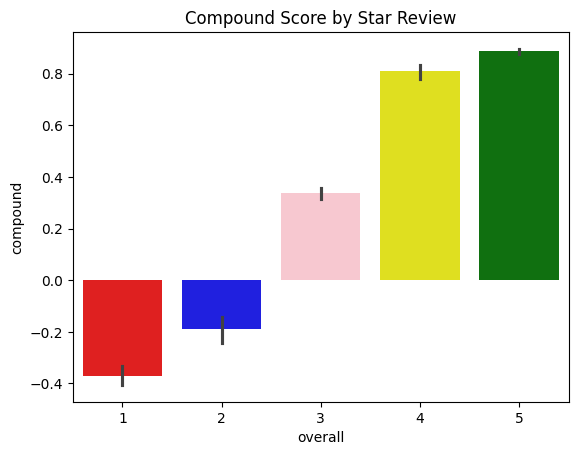

In [59]:
plot_vaders =sns.barplot(data=vaders, x='overall', y = 'compound', palette=['red', 'blue', 'pink','yellow', 'green'])
plot_vaders.set_title('Compound Score by Star Review')
plt.show()

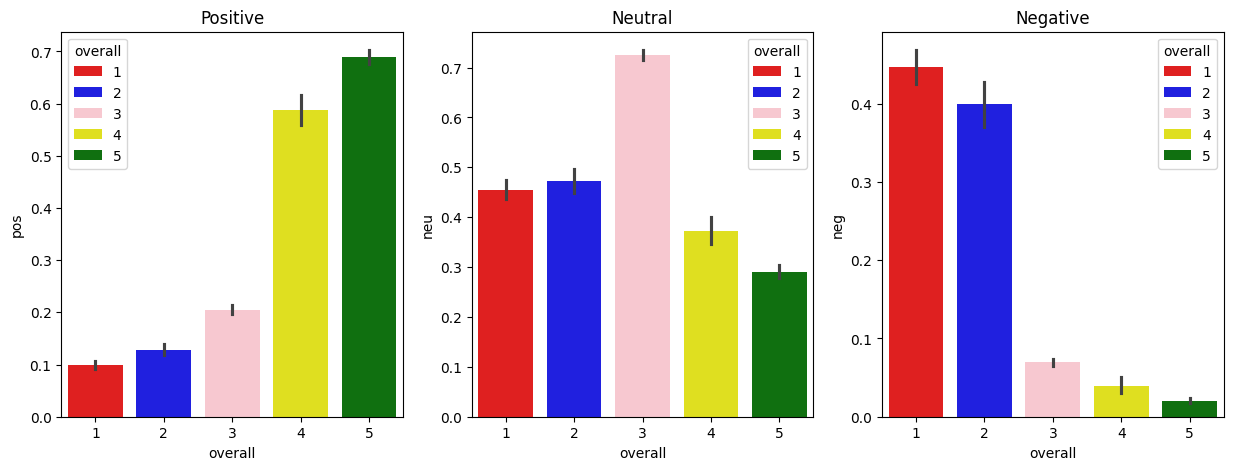

In [60]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=vaders, x='overall', y='pos', hue='overall', palette=['red', 'blue', 'pink','yellow', 'green'], ax = axs[0])
sns.barplot(data=vaders, x='overall', y='neu', hue='overall', palette=['red', 'blue', 'pink','yellow', 'green'], ax = axs[1])
sns.barplot(data=vaders, x='overall', y='neg', hue='overall', palette=['red', 'blue', 'pink','yellow', 'green'], ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [61]:
def get_sentiment_vader(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)

    # Get sentiment scores using the custom sentiment analysis function
    custom_scores = custom_sentiment_analysis(text)
    pos_score = custom_scores["pos"]
    compound = custom_scores["compound"]


    if compound == 1.0:
        return 'Positive'

    elif compound > 0.38:  # Adjust threshold as needed
        return 'Positive'

    elif compound < 0.0:  # Adjust threshold as needed
        return 'Negative'

    else:
        return 'Neutral'


In [62]:
text = "compatible windows"
predicted_sentiment = get_sentiment_vader(text)
print("Predicted Sentiment:", predicted_sentiment)


Predicted Sentiment: Neutral


In [63]:
vaders['predicted_vaders'] = vaders['text'].apply(get_sentiment_vader)
vaders

,Index,neg,neu,pos,compound,sentiment,overall,asin,text,text_length,predicted_vaders
0,223185,0.000,0.345,0.655,0.9638,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,Positive
1,128361,0.059,0.480,0.461,0.9523,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,Positive
2,121823,0.000,0.282,0.718,0.9855,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,Positive
3,41391,0.000,0.452,0.548,0.8658,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,Positive
4,11742,0.111,0.622,0.267,0.7775,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,Positive
...,...,...,...,...,...,...,...,...,...,...,...
5995,263696,0.112,0.693,0.195,0.9222,Negative,2,B0167ZFTSY,dont feel like product marketed way item wasnt really hopping sized reading reviews found item fit little large style also wasnt really expected fair though dont feel like product marketed way misleading got looks like photographs didnt wear way hopped fits though meant much younger girl also isnt curve sweater naturally curvy look top may bit flattering im not super curvy though least not top feel like looked little childish say material quite nice arrived good condition made thicker fabric nothing wrong quality im ft lbs natural waist wear b suggestion smaller builds closer mine would go small youve got natural curves go medium guess smaller size would form someones body shape look less childish potential buyers whos curves little less pronounced also please note item ships china get wrong size expensive return went back forth amazon customer service effort find solution helpful process not everyone time patience prepared keep get,1579,Positive
5996,247626,1.000,0.000,0.000,-1.0000,Negative,2,B00QDJ4SV4,two stars turned neck green,31,Negative
5997,270824,1.000,0.000,0.000,-1.0000,Negative,1,B01AMSIDI0,one star order size smaller way big,38,Negative
5998,249159,1.000,0.000,0.000,-1.0000,Negative,1,B00S9VIU4K,one star big,16,Negative


In [64]:
# Filter the DataFrame for rows where the sentiment column is 'Neutral'
neutral_vader_df = vaders[vaders['sentiment'] == 'Negative']

# Print the first few rows of the filtered DataFrame

neutral_vader_df.head(1000)

,Index,neg,neu,pos,compound,sentiment,overall,asin,text,text_length,predicted_vaders
4000,220197,0.000,0.949,0.051,0.2235,Negative,2,B001HLG80W,leather seems rotting even application reputable water repellent mink oilthe leather pocks lifts everywhere rain hits almost think wasnt meant worn outside glue holding bandana seems least partially water soluble one wearing rain almost completely gone,337,Neutral
4001,153090,0.406,0.399,0.196,-0.2755,Negative,2,B00YFS31LS,not worth see loose not good materialdesign,76,Negative
4002,259637,1.000,0.000,0.000,-1.0000,Negative,1,B013LXGXVM,one star breast big waist narrow total waste money information misleading wouldnt encourage anyone buy picture website pretty n hand piece crap,195,Negative
4003,210683,0.659,0.341,0.000,-0.7003,Negative,2,B01FO04LGE,no chinese cheap terribly small,35,Negative
4004,162783,1.000,0.000,0.000,-1.0000,Negative,2,B011I12NMW,two stars cheap known given price way big,77,Negative
...,...,...,...,...,...,...,...,...,...,...,...
4995,258001,1.000,0.000,0.000,-1.0000,Negative,1,B011KQD004,one star stupidest cloth ever,29,Negative
4996,144083,1.000,0.000,0.000,-1.0000,Negative,1,B00WMNEJYG,one star see crappiest material cheap made someone feet tall,80,Negative
4997,66654,1.000,0.000,0.000,-1.0000,Negative,1,B00BBB844Q,one star fugly,18,Negative
4998,76608,1.000,0.000,0.000,-1.0000,Negative,1,B00DP5NNHY,one star suspenders broke first day son wore,61,Negative


predicted_vaders
Positive    3359
Negative    1537
Neutral     1104
Name: count, dtype: int64


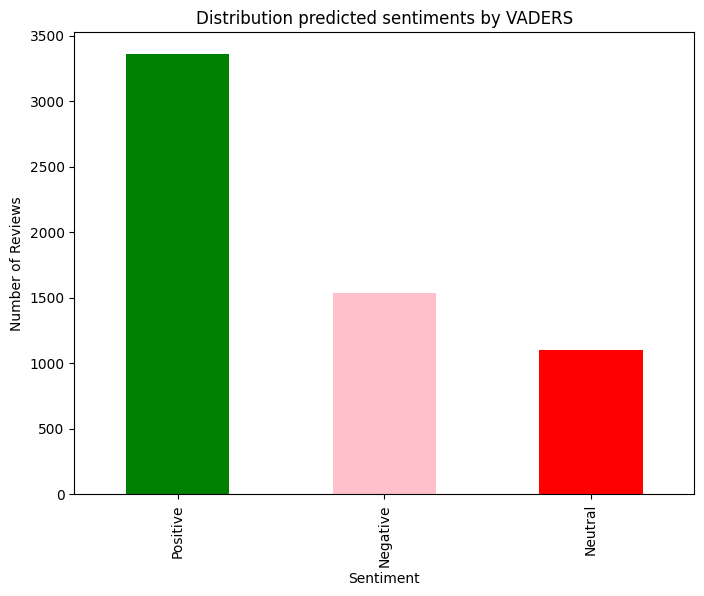

In [65]:
sentiment_counts_vaders = vaders['predicted_vaders'].value_counts()
print(sentiment_counts_vaders)

plt.figure(figsize=(8, 6))
sentiment_counts_vaders.plot(kind='bar', color=['green', 'pink', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution predicted sentiments by VADERS')
plt.show()

In [66]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

accuracy_score_vader = accuracy_score(vaders['sentiment'],vaders['predicted_vaders'])
print(f"VADERS Accuracy Score: {accuracy_score_vader}")


VADERS Accuracy Score: 0.6593333333333333


In [67]:
print("VADERS Classification Report")
print(f"VADERS Accuracy Score: {accuracy_score_vader}")
print(classification_report(vaders['sentiment'],vaders['predicted_vaders']))

VADERS Classification Report
VADERS Accuracy Score: 0.6593333333333333
              precision    recall  f1-score   support

    Negative       0.82      0.63      0.71      2000
     Neutral       0.70      0.39      0.50      2000
    Positive       0.57      0.96      0.72      2000

    accuracy                           0.66      6000
   macro avg       0.70      0.66      0.64      6000
weighted avg       0.70      0.66      0.64      6000



Text Blob Models

In [68]:
from textblob import TextBlob

In [69]:
result_textblob = {}

for i, row in tqdm(subset_df.iterrows(), total=subset_df.shape[0]):
    text = str(row['text'])
    myid = row['Index']
    sentiment = TextBlob(text).sentiment
    result_textblob[myid] = sentiment

  0%|          | 0/6000 [00:00<?, ?it/s]

In [70]:
result_textblob

{223185: Sentiment(polarity=0.4916666666666667, subjectivity=0.7000000000000001),
 128361: Sentiment(polarity=0.44761904761904764, subjectivity=0.6357142857142858),
 121823: Sentiment(polarity=0.4833333333333334, subjectivity=0.7350000000000001),
 41391: Sentiment(polarity=0.41111111111111115, subjectivity=0.75),
 11742: Sentiment(polarity=0.27653061224489794, subjectivity=0.4836734693877551),
 167674: Sentiment(polarity=0.675, subjectivity=0.8),
 87651: Sentiment(polarity=0.39999999999999997, subjectivity=0.5375),
 224759: Sentiment(polarity=0.21428571428571427, subjectivity=0.42857142857142855),
 21420: Sentiment(polarity=0.63, subjectivity=0.53),
 214637: Sentiment(polarity=0.44285714285714284, subjectivity=0.7678571428571428),
 158523: Sentiment(polarity=0.13435374149659862, subjectivity=0.4031746031746032),
 86803: Sentiment(polarity=0.6, subjectivity=0.8),
 86713: Sentiment(polarity=0.375, subjectivity=0.4),
 247422: Sentiment(polarity=0.7, subjectivity=0.6000000000000001),
 2575

In [71]:
blob = pd.DataFrame(result_textblob).T


In [72]:
blob = blob.reset_index().rename(columns={'index':'Index'})
blob = blob.merge(subset_df, how='left')

In [73]:
blob.rename(columns={0: 'polarity', 1: 'subjectivity'}, inplace=True)

In [74]:
blob

,Index,polarity,subjectivity,sentiment,overall,asin,text,text_length
0,223185,0.491667,0.700000,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153
1,128361,0.447619,0.635714,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239
2,121823,0.483333,0.735000,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188
3,41391,0.411111,0.750000,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132
4,11742,0.276531,0.483673,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309
...,...,...,...,...,...,...,...,...
5995,263696,-0.008274,0.510952,Negative,2,B0167ZFTSY,dont feel like product marketed way item wasnt really hopping sized reading reviews found item fit little large style also wasnt really expected fair though dont feel like product marketed way misleading got looks like photographs didnt wear way hopped fits though meant much younger girl also isnt curve sweater naturally curvy look top may bit flattering im not super curvy though least not top feel like looked little childish say material quite nice arrived good condition made thicker fabric nothing wrong quality im ft lbs natural waist wear b suggestion smaller builds closer mine would go small youve got natural curves go medium guess smaller size would form someones body shape look less childish potential buyers whos curves little less pronounced also please note item ships china get wrong size expensive return went back forth amazon customer service effort find solution helpful process not everyone time patience prepared keep get,1579
5996,247626,-0.200000,0.300000,Negative,2,B00QDJ4SV4,two stars turned neck green,31
5997,270824,0.000000,0.300000,Negative,1,B01AMSIDI0,one star order size smaller way big,38
5998,249159,0.000000,0.100000,Negative,1,B00S9VIU4K,one star big,16


C:\Users\hasee\AppData\Local\Temp\ipykernel_18364\2760719762.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_blob =sns.barplot(data=blob, x='overall', y = 'polarity', palette=['red', 'blue', 'pink','yellow', 'green'])


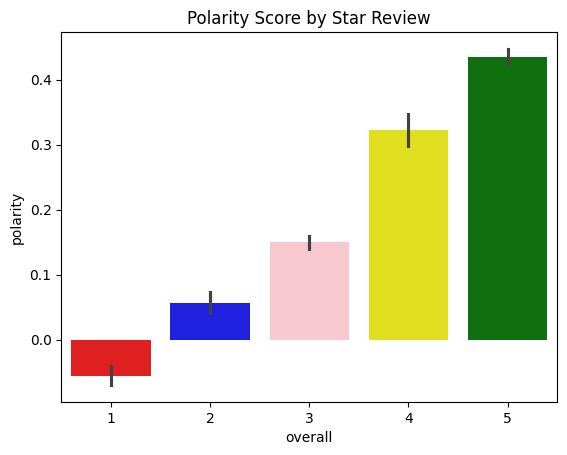

In [75]:
plot_blob =sns.barplot(data=blob, x='overall', y = 'polarity', palette=['red', 'blue', 'pink','yellow', 'green'])
plot_blob.set_title('Polarity Score by Star Review')
plt.show()

In [76]:

def get_sentiment(polarity):

    if  polarity < 0.05:
        return 'Negative'
    elif polarity > 0.16:
        return 'Positive'
    else:
        return 'Neutral'

In [77]:
blob['predicted_textblob'] = blob['text'].apply(lambda x: get_sentiment(TextBlob(x).sentiment.polarity))
blob

,Index,polarity,subjectivity,sentiment,overall,asin,text,text_length,predicted_textblob
0,223185,0.491667,0.700000,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,Positive
1,128361,0.447619,0.635714,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,Positive
2,121823,0.483333,0.735000,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,Positive
3,41391,0.411111,0.750000,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,Positive
4,11742,0.276531,0.483673,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,Positive
...,...,...,...,...,...,...,...,...,...
5995,263696,-0.008274,0.510952,Negative,2,B0167ZFTSY,dont feel like product marketed way item wasnt really hopping sized reading reviews found item fit little large style also wasnt really expected fair though dont feel like product marketed way misleading got looks like photographs didnt wear way hopped fits though meant much younger girl also isnt curve sweater naturally curvy look top may bit flattering im not super curvy though least not top feel like looked little childish say material quite nice arrived good condition made thicker fabric nothing wrong quality im ft lbs natural waist wear b suggestion smaller builds closer mine would go small youve got natural curves go medium guess smaller size would form someones body shape look less childish potential buyers whos curves little less pronounced also please note item ships china get wrong size expensive return went back forth amazon customer service effort find solution helpful process not everyone time patience prepared keep get,1579,Negative
5996,247626,-0.200000,0.300000,Negative,2,B00QDJ4SV4,two stars turned neck green,31,Negative
5997,270824,0.000000,0.300000,Negative,1,B01AMSIDI0,one star order size smaller way big,38,Negative
5998,249159,0.000000,0.100000,Negative,1,B00S9VIU4K,one star big,16,Negative


predicted_textblob
Positive    3096
Negative    2101
Neutral      803
Name: count, dtype: int64


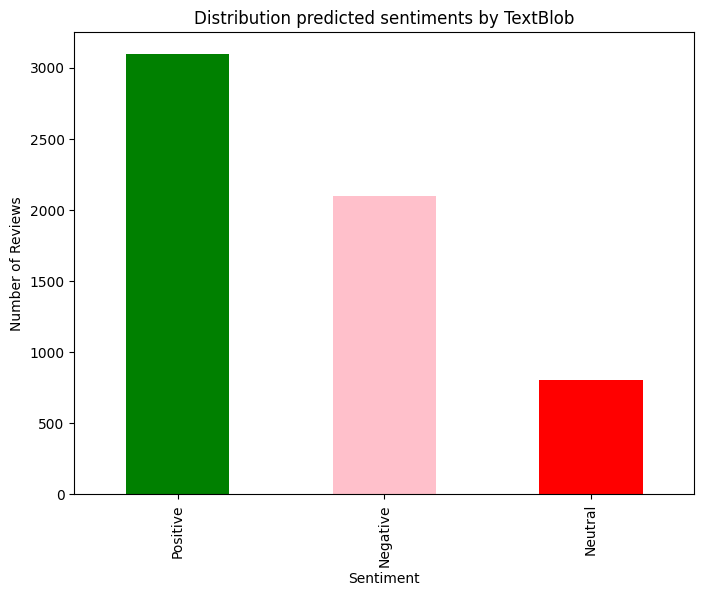

In [78]:
sentiment_counts = blob['predicted_textblob'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'pink', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution predicted sentiments by TextBlob')
plt.show()

In [79]:
accuracy_score_textblob = accuracy_score(blob['sentiment'],blob['predicted_textblob'])
print(f"TEXTBLOB Accuracy Score: {accuracy_score_textblob}")

TEXTBLOB Accuracy Score: 0.5528333333333333


In [80]:
accuracy_score_textblob = accuracy_score(blob['sentiment'],blob['predicted_textblob'])
print(f"TEXTBLOB Accuracy Score: {accuracy_score_textblob}")
print(classification_report(blob['sentiment'],blob['predicted_textblob']))

TEXTBLOB Accuracy Score: 0.5528333333333333
              precision    recall  f1-score   support

    Negative       0.59      0.62      0.61      2000
     Neutral       0.49      0.20      0.28      2000
    Positive       0.54      0.84      0.66      2000

    accuracy                           0.55      6000
   macro avg       0.54      0.55      0.52      6000
weighted avg       0.54      0.55      0.52      6000



In [81]:
subset_df

,sentiment,overall,asin,text,text_length,Index
0,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,223185
1,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,128361
2,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,121823
3,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,41391
4,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,11742
...,...,...,...,...,...,...
5995,Negative,2,B0167ZFTSY,dont feel like product marketed way item wasnt really hopping sized reading reviews found item fit little large style also wasnt really expected fair though dont feel like product marketed way misleading got looks like photographs didnt wear way hopped fits though meant much younger girl also isnt curve sweater naturally curvy look top may bit flattering im not super curvy though least not top feel like looked little childish say material quite nice arrived good condition made thicker fabric nothing wrong quality im ft lbs natural waist wear b suggestion smaller builds closer mine would go small youve got natural curves go medium guess smaller size would form someones body shape look less childish potential buyers whos curves little less pronounced also please note item ships china get wrong size expensive return went back forth amazon customer service effort find solution helpful process not everyone time patience prepared keep get,1579,263696
5996,Negative,2,B00QDJ4SV4,two stars turned neck green,31,247626
5997,Negative,1,B01AMSIDI0,one star order size smaller way big,38,270824
5998,Negative,1,B00S9VIU4K,one star big,16,249159


In [82]:
pd.set_option('display.max_colwidth', None)
subset_df.head(30)

,sentiment,overall,asin,text,text_length,Index
0,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,223185
1,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,128361
2,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,121823
3,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,41391
4,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,11742
5,Positive,5,B0140UN3CC,five stars love watch beautiful however snug,66,167674
6,Positive,5,B00G8Q7JZ4,love ring love ring perfect fit shipped swiftly would definitely order mj metals jewelry future,149,87651
7,Positive,5,B006111O7K,five stars size large,30,224759
8,Positive,5,B000YFSR5G,best sweatpants ever bought best pair sweat pants ever bought comfortable length perfect something ones bought past not would not hesitate buy another pair like,237,21420
9,Positive,5,B01GGEQSWM,five stars nice fits right ordering colors,65,214637


Machine Learning

In [83]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(subset_df['text'], subset_df['sentiment'], test_size=0.3, stratify=subset_df['sentiment'], random_state=42)

In [84]:

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_)
X_test_vec = vectorizer.transform(X_test_)

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# Logistic Regression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_vec, y_train_)

print("Logistic Regression Accuracy:", logistic_classifier.score(X_train_vec,y_train_))

# SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_vec, y_train_)

print("SVM Accuracy:", svm_classifier.score(X_train_vec,y_train_))

# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train_)

print("Naive Bayes Accuracy:", nb_classifier.score(X_train_vec,y_train_))

# Gradient Boosting
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_vec, y_train_)

print("Gradient Boosting Accuracy:", gb_classifier.score(X_train_vec,y_train_))

# MLP (Multi-layer Perceptron)
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train_vec, y_train_)

print("MLP Accuracy:", mlp_classifier.score(X_train_vec,y_train_))

Logistic Regression Accuracy: 0.919047619047619
SVM Accuracy: 0.9319047619047619
Naive Bayes Accuracy: 0.9016666666666666
Gradient Boosting Accuracy: 0.8628571428571429
MLP Accuracy: 1.0


In [86]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(class_weight='balanced', max_iter=10000), param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_vec, y_train_)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

# Calculate accuracy
accuracy = accuracy_score(y_test_, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_, y_pred))


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.7847619047619048
Accuracy: 0.7611111111111111
Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.79      0.77       600
     Neutral       0.68      0.69      0.68       600
    Positive       0.86      0.80      0.83       600

    accuracy                           0.76      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.76      0.76      0.76      1800



In [87]:
svm_model = SVC(C=1, gamma='scale', kernel='rbf', max_iter=30000)
svm_model.fit(X_train_vec, y_train_)
y_pred = svm_model.predict(X_test_vec)
accuracy = accuracy_score(y_test_, y_pred)
print(f"SVM Accuracy: {accuracy:.2f}")
print(classification_report(y_test_, y_pred))

SVM Accuracy: 0.76
              precision    recall  f1-score   support

    Negative       0.76      0.79      0.77       600
     Neutral       0.68      0.69      0.68       600
    Positive       0.86      0.80      0.83       600

    accuracy                           0.76      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.76      0.76      0.76      1800



In [88]:
lr_model = LogisticRegression(
    solver='saga',          # Optimization algorithm
    max_iter=1000,          # Maximum number of iterations
    C=1,                  # Regularization parameter
    penalty='l2',           # Regularization penalty (l1 or l2)
    class_weight=None,      # Class weights (None for no adjustment)
    random_state=42         # Random state for reproducibility
)
lr_model.fit(X_train_vec, y_train_)
y_pred = lr_model.predict(X_test_vec)
accuracy = accuracy_score(y_test_, y_pred)
print(f"LR Accuracy: {accuracy:.2f}")
print(classification_report(y_test_, y_pred))


LR Accuracy: 0.77
              precision    recall  f1-score   support

    Negative       0.76      0.81      0.78       600
     Neutral       0.71      0.66      0.69       600
    Positive       0.83      0.82      0.83       600

    accuracy                           0.77      1800
   macro avg       0.77      0.77      0.77      1800
weighted avg       0.77      0.77      0.77      1800



In [89]:
# Filter the DataFrame to include only the testing rows
testing_subset_df = subset_df.loc[X_test_.index]
testing_subset_df['predicted_sentiment'] = lr_model.predict(X_test_vec)
accuracy = accuracy_score(y_test_, y_pred)
print(f"Accuracy of Adjusted Ratings: {accuracy:.2f}")

# Adjust ratings based on predicted sentiment for the testing data
adjusted_ratings_test = []
for sentiment, original_rating in zip(testing_subset_df['predicted_sentiment'], testing_subset_df['overall']):
    if sentiment == "Positive":
        adjusted_rating = min(original_rating + 1, 5)  # Increase rating for positive sentiment
    elif sentiment == "Negative":
        adjusted_rating = max(original_rating - 1, 1)  # Decrease rating for negative sentiment
    else:
        adjusted_rating = original_rating  # No adjustment for neutral sentiment
    adjusted_ratings_test.append(adjusted_rating)

# Update the testing data with adjusted ratings
testing_subset_df['adjusted_rating'] = adjusted_ratings_test

# Display only the testing section with adjusted ratings
print(testing_subset_df[['overall', 'sentiment', 'predicted_sentiment','adjusted_rating']].head())



Accuracy of Adjusted Ratings: 0.77
      overall sentiment predicted_sentiment  adjusted_rating
5207        2  Negative            Negative                1
3818        3   Neutral             Neutral                3
4396        1  Negative            Negative                1
3477        3   Neutral             Neutral                3
1787        4  Positive            Positive                5


In [90]:
testing_subset_df

,sentiment,overall,asin,text,text_length,Index,predicted_sentiment,adjusted_rating
5207,Negative,2,B00ZQ7K4X0,two stars top low regifted someone else,60,156205,Negative,1
3818,Neutral,3,B00CWEZZQ6,nice piece cheap jewelry nice piece cheap jewelry hasnt worked expected friends raved negative ion everything aches pains not noticed difference mine,215,71622,Neutral,3
4396,Negative,1,B00VI91Q78,one star bad defective product,37,140646,Negative,1
3477,Neutral,3,B00PDACJ42,three stars seems somewhat cheap,32,121772,Neutral,3
1787,Positive,4,B017I5IN6M,four stars really pretty not overly fussylove,57,180102,Positive,5
...,...,...,...,...,...,...,...,...
330,Positive,5,B00ADRG45A,excellent coin purse great divider creating one side coins one side bills not organized fashionable,160,228488,Negative,4
3675,Neutral,3,B00H589AEW,nice casual nice casual hat,27,93146,Positive,4
4219,Negative,1,B00L0T7BW0,one star large,17,241771,Negative,1
3142,Neutral,3,B01EMCB9QU,three stars material thin,29,277804,Neutral,3


In [91]:
from sklearn.neural_network import MLPClassifier


# Define hyperparameters to experiment with
hidden_layer_sizes = [(100,), (50,), (100, 50), (50, 25)]
activations = ['relu']
solvers = ['sgd']
max_iters = [1000]
alphas = [0.01]

# Loop over each set of hyperparameters
for hidden_layer_size in hidden_layer_sizes:
    for activation in activations:
        for solver in solvers:
            for max_iter in max_iters:
                for alpha in alphas:
                    # Define and train the MLP classifier with the current hyperparameters
                    mlp_model = MLPClassifier(
                        hidden_layer_sizes=hidden_layer_size,
                        activation=activation,
                        solver=solver,
                        max_iter=max_iter,
                        alpha=alpha,
                        random_state=42
                    )
                    mlp_model.fit(X_train_vec, y_train_)

                    # Make predictions on the test set
                    y_pred = mlp_model.predict(X_test_vec)

                    # Evaluate the model's performance
                    accuracy = accuracy_score(y_test_, y_pred)
                    print(f"Hidden Layers: {hidden_layer_size}, Activation: {activation}, Solver: {solver}, Max Iter: {max_iter}, Alpha: {alpha}, Accuracy: {accuracy:.2f}")
                    print(classification_report(y_test_, y_pred))


C:\Users\hasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (100,), Activation: relu, Solver: sgd, Max Iter: 1000, Alpha: 0.01, Accuracy: 0.76
              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78       600
     Neutral       0.70      0.67      0.68       600
    Positive       0.82      0.83      0.82       600

    accuracy                           0.76      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.76      0.76      0.76      1800



C:\Users\hasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (50,), Activation: relu, Solver: sgd, Max Iter: 1000, Alpha: 0.01, Accuracy: 0.77
              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78       600
     Neutral       0.70      0.68      0.69       600
    Positive       0.82      0.83      0.82       600

    accuracy                           0.77      1800
   macro avg       0.76      0.77      0.76      1800
weighted avg       0.76      0.77      0.76      1800



C:\Users\hasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layers: (100, 50), Activation: relu, Solver: sgd, Max Iter: 1000, Alpha: 0.01, Accuracy: 0.74
              precision    recall  f1-score   support

    Negative       0.76      0.75      0.75       600
     Neutral       0.66      0.64      0.65       600
    Positive       0.80      0.82      0.81       600

    accuracy                           0.74      1800
   macro avg       0.74      0.74      0.74      1800
weighted avg       0.74      0.74      0.74      1800

Hidden Layers: (50, 25), Activation: relu, Solver: sgd, Max Iter: 1000, Alpha: 0.01, Accuracy: 0.74
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76       600
     Neutral       0.66      0.66      0.66       600
    Positive       0.80      0.81      0.81       600

    accuracy                           0.74      1800
   macro avg       0.74      0.74      0.74      1800
weighted avg       0.74      0.74      0.74      1800



C:\Users\hasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [92]:
best_mlp_model = MLPClassifier(
                        hidden_layer_sizes=(50,),
                        activation='relu',
                        solver='sgd',
                        max_iter=1000,
                        alpha=0.1,
                        random_state=42
                    )
best_mlp_model.fit(X_train_vec, y_train_)

# Make predictions on the test set
y_pred = best_mlp_model.predict(X_test_vec)

# Evaluate the model's performance
accuracy = accuracy_score(y_test_, y_pred)
print("Hidden Layers: (50,), Activation: relu, Solver: sgd, Max Iter: 1000, Alpha: 0.1,")
print(f"MLP Accuracy: {accuracy:.2f}")
print(classification_report(y_test_, y_pred))


Hidden Layers: (50,), Activation: relu, Solver: sgd, Max Iter: 1000, Alpha: 0.1,
MLP Accuracy: 0.77
              precision    recall  f1-score   support

    Negative       0.77      0.80      0.78       600
     Neutral       0.70      0.68      0.69       600
    Positive       0.82      0.83      0.83       600

    accuracy                           0.77      1800
   macro avg       0.77      0.77      0.77      1800
weighted avg       0.77      0.77      0.77      1800



C:\Users\hasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [93]:
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(best_mlp_model, 'mlp_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [94]:
# Transform text data into feature vectors
X_vec = vectorizer.transform(subset_df['text'])

# Predict sentiment for the entire dataset
subset_df['predicted_sentiment'] = lr_model.predict(X_vec)

accuracy = accuracy_score(subset_df['sentiment'], subset_df['predicted_sentiment'])
print(f"Accuracy of Predicted Sentiment: {accuracy:.2f}")
# Adjust ratings based on predicted sentiment
adjusted_ratings = []
for sentiment, original_rating in zip(subset_df['predicted_sentiment'], subset_df['overall']):
    if sentiment == "Positive":
        adjusted_rating = min(original_rating + 1, 5)  # Increase rating for positive sentiment
    elif sentiment == "Negative":
        adjusted_rating = max(original_rating - 1, 1)  # Decrease rating for negative sentiment
    else:
        adjusted_rating = original_rating  # No adjustment for neutral sentiment
    adjusted_ratings.append(adjusted_rating)

# Update the DataFrame with adjusted ratings
subset_df['adjusted_rating'] = adjusted_ratings

# Display the entire DataFrame with adjusted ratings
print(subset_df[['overall', 'sentiment', 'predicted_sentiment', 'adjusted_rating']].head())


Accuracy of Predicted Sentiment: 0.87
   overall sentiment predicted_sentiment  adjusted_rating
0        5  Positive            Positive                5
1        5  Positive            Positive                5
2        5  Positive            Positive                5
3        4  Positive            Positive                5
4        4  Positive            Positive                5


In [95]:
subset_df

,sentiment,overall,asin,text,text_length,Index,predicted_sentiment,adjusted_rating
0,Positive,5,B004YFVACE,great beautiful belt love design color leather looks great jeans definitely purchase another different color,153,223185,Positive,5
1,Positive,5,B00RLSCLJM,absolutely love ring absolutely love ring especially price reading reviews worried color matching white gold ring matches perfectly ring fits great received quickly,239,128361,Positive,5
2,Positive,5,B00PDACJ42,super cute love super cute love fits perfectly skirt velcro room tighten loosen putting great price whole outfit decent quality,188,121823,Positive,5
3,Positive,4,B004K3J7LG,great seller quick shipper product described price far would recommend friends,132,41391,Positive,5
4,Positive,4,B000NBIMY2,great flip flop normally wear flip flops get smidge extra shoe heel size not offer enough smidge think size would not looked right no arch support sole shoe sturdy good shoe ones comfy,309,11742,Positive,5
...,...,...,...,...,...,...,...,...
5995,Negative,2,B0167ZFTSY,dont feel like product marketed way item wasnt really hopping sized reading reviews found item fit little large style also wasnt really expected fair though dont feel like product marketed way misleading got looks like photographs didnt wear way hopped fits though meant much younger girl also isnt curve sweater naturally curvy look top may bit flattering im not super curvy though least not top feel like looked little childish say material quite nice arrived good condition made thicker fabric nothing wrong quality im ft lbs natural waist wear b suggestion smaller builds closer mine would go small youve got natural curves go medium guess smaller size would form someones body shape look less childish potential buyers whos curves little less pronounced also please note item ships china get wrong size expensive return went back forth amazon customer service effort find solution helpful process not everyone time patience prepared keep get,1579,263696,Negative,1
5996,Negative,2,B00QDJ4SV4,two stars turned neck green,31,247626,Negative,1
5997,Negative,1,B01AMSIDI0,one star order size smaller way big,38,270824,Negative,1
5998,Negative,1,B00S9VIU4K,one star big,16,249159,Negative,1


In [96]:
filtered_reviews = subset_df[subset_df['text'].apply(lambda x: len(x.split()) > 100)]

n_reviews = min(10, len(filtered_reviews))
all_reviewtext = " ".join(filtered_reviews['text'].iloc[:n_reviews].astype(str))

In [97]:
filtered_reviews

,sentiment,overall,asin,text,text_length,Index,predicted_sentiment,adjusted_rating
504,Positive,5,B0017JF4FO,absolutely love bag tried replace old leather bag vinyl one vinyl wore piping looked full marks stains months didnt want pay fortune leather bag want something would organize everything small space since feet tall larger bags big carry one everything could wanted holding well far love fact carry shopping list coupons calculator checkbooks front pocket room spare interior organizes things two compartments lots pockets around use side pocket keys perfect bag everyday use thing dont like double adjustable strap would preferred single substantial strap one slips gets longer time periodically shorten also tends get twisted straighten time time however consider minor flaw compared overall utility usefulness rest features like fact use regular shoe polish ever gets scuffed make shiny,1280,23516,Positive,5
688,Positive,5,B00TT4LKE8,movement great unfortunately knee surgery several years ago getting better never ive primarily used trusted yonex shows badminton years theyve served well favorite far shoe used prior still pretty good shape started feel little hesitant movements decided get new pair im glad one picked movement great feel comfortable moving back making clearing shot smash feel comfortable move forward deal dropped shot also feel comfortable moving side side well needless say better movement across board better shot winning points quick minor point closingive worn white shoes badminton prior pair couple players badminton club wore decided wouldnt bad break tradition though get flashy looking pair change,1062,250790,Positive,5
748,Positive,4,B00GXE331K,nice looking good job little money get room nicer wallet fine metal walletcredit card holder pros finish excellent nice looking pretty slim exactly closed good latch hinge great warranty however things not care corners rounded one direction still creates distinct edge not open far others seen degrees without forcing not hold much others seen get cards cash trifolded gets little tight dont carry cash probably get cards would tight depending thickness cards not rfid blocking certification fips one bought credit card holder silver stainless steel rfid blocking credit card protector men women latest slim metal case stylish travel wallet gift best protection bank id cards rfid scanners money back guaranteenbspalso not rfid certification larger expensive opens full degrees wo forcing holds another member family liked bryk wallet kept one works better,1740,91647,Neutral,4
827,Positive,4,B005N7YWX6,ordered bellaband black white reading best band market plus hair tie trick could rate stars would ordered bellaband black white reading best band market plus hair tie trick wasnt cutting anymore today first full day wearing pros fits well im size jean normally ordered holds jeans well not tell pants underneath actually unbuttoned creates smooth appearance wear different ways depending stage pregnancy con rides bit adjust times uncomfortable lift using restroom feels tight silicone sticks skin overall happy decided buy weeks pregnant havent gained much size yet see working normal jeans great longer goal stay regular jeans summer switch dresses maternity shorts definitely trick,1081,46864,Positive,5
1229,Positive,4,B01D67EL6C,weird color highly functional recommended like wallet slim easy carry slips pocket forget even time still enough storage options carry anything would need unless one people crams everything wallet use long term storage design perfect carry work id windowed slot easy identification along drivers license second slot opposite side carries payment options debit credit card behind card sets keep blank check one side health insurance card leaves main center pocket cash thats need complaint item would leather not highest quality leather color looks bad opinion fair color exactly appears photos orangered looking think makes look cheap still using daily carry function form 